In [ ]:
# Install conda
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
# Check conda installation
import condacolab
condacolab.check()

# Install required packages
!mamba install -c conda-forge pandas numpy matplotlib rdkit scikit-learn seaborn graphviz pydotplus

# Download required files
!wget https://github.com/lillgroup/AIiDD/releases/download/v2.0.0/lab1.tar.gz
!tar -xzvf lab1.tar.gz

# Classification using Decision Trees

In this notebook, we will use decision trees and physicochemical descriptors to classify compounds between those having decent blood brain barrier (BBB) penetration and those with do not.

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, Crippen, AllChem

There are some Warnings informing about future scipy changes.

We will suppress them here as they have no influence on the results.

In [ ]:
# import warnings filter
from warnings import simplefilter

# ignore all future warnings
simplefilter(action="ignore", category=FutureWarning)

### Read data

Here we use classification data on blood brain barrier (BBB) penetration.

In [ ]:
tmp = pd.read_table("B3DB_classification.tsv", sep="\t")

table = tmp.loc[:, ("compound_name", "IUPAC_name", "SMILES", "BBB+/BBB-")]
table = table.dropna(subset="BBB+/BBB-")
table.reset_index(drop=True, inplace=True)

table.loc[:, "BBB_class"] = 0
table.loc[table["BBB+/BBB-"] == "BBB+", "BBB_class"] = 1

# Drop the rows where molecule generated from SMILES sequence is none
table = table[table["SMILES"].apply(lambda x: Chem.MolFromSmiles(x) is not None)]

table

### Molecular descriptors calculation

We can use RDKIT to calculate several molecular descriptors (2D and 3D).

In [ ]:
# We will calculate the descriptors and add them to our table
for i in table.index:
    mol = Chem.MolFromSmiles(table.loc[i, "SMILES"])
    table.loc[i, "MolWt"] = Descriptors.ExactMolWt(mol)
    table.loc[i, "TPSA"] = Chem.rdMolDescriptors.CalcTPSA(
        mol
    )  # Topological Polar Surface Area
    table.loc[i, "nRotB"] = Descriptors.NumRotatableBonds(
        mol
    )  # Number of rotable bonds
    table.loc[i, "HBD"] = Descriptors.NumHDonors(mol)  # Number of H bond donors
    table.loc[i, "HBA"] = Descriptors.NumHAcceptors(mol)  # Number of H bond acceptors
    table.loc[i, "LogP"] = Descriptors.MolLogP(mol)  # LogP

table

### Model: We will use decision tree classification

Generate x (descriptors) and y (BBB_class) vectors

In [ ]:
descriptors_selected = ["MolWt", "TPSA", "HBD", "HBA", "LogP"]

x = table.loc[:, descriptors_selected].values
y = table.loc[:, ["BBB_class"]].values

#### Split data into training and test set

Here, we use random splitting

In [ ]:
# train test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=0.25, random_state=1
)

#### Generate model

Next, we perform decision tree classification using maximum depth of 3

In [ ]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=3)
clf = clf.fit(x_train, y_train)

print("maximum depth: {} nn score: {} ".format(3, clf.score(x_valid, y_valid)))

#### Export graph of tree

In [ ]:
import graphviz
import pydotplus

try:
    from StringIO import StringIO  ## for Python 2
except ImportError:
    from io import StringIO  ## for Python 3


dt_data = StringIO()
tree.export_graphviz(
    clf,
    out_file=dt_data,
    feature_names=descriptors_selected,
    class_names=["BBB-", "BBB+"],
    filled=True,
    rounded=True,
    special_characters=True,
)
graph = pydotplus.graph_from_dot_data(dt_data.getvalue())
graph.write_png("my_decision_tree.png")

#### Tree depth

We will repeat decision tree classification for different maximum depth values

In [ ]:
# check dependency on max_depth
score_list = []
for maxd in range(1, 25):
    clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=maxd)
    clf = clf.fit(x_train, y_train)
    score_list.append(clf.score(x_valid, y_valid))

plt.plot(range(1, 25), score_list)
plt.xlabel("k values")
plt.ylabel("accuracy")
plt.show()

Take the best max_depth value


In [ ]:
# knn model
clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=20)
clf = clf.fit(x_train, y_train)

prediction = clf.predict(x_test)
print(" {} nn score: {} ".format(20, clf.score(x_test, y_test)))

#### Confusion matrix

To better visualize the results we compute the confusion matrix highlighting number of true negative (top-left), true positive (bottom-right), false negatives (bottom-left) and false positive (top-right) samples.

In [ ]:
# %% confusion matrix
y_pred = clf.predict(x_test)
y_true = y_test

from sklearn.metrics import confusion_matrix, precision_score, recall_score

cm = confusion_matrix(y_true, y_pred)

# %% cm visualization
import seaborn as sns

f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Compute classification metrics

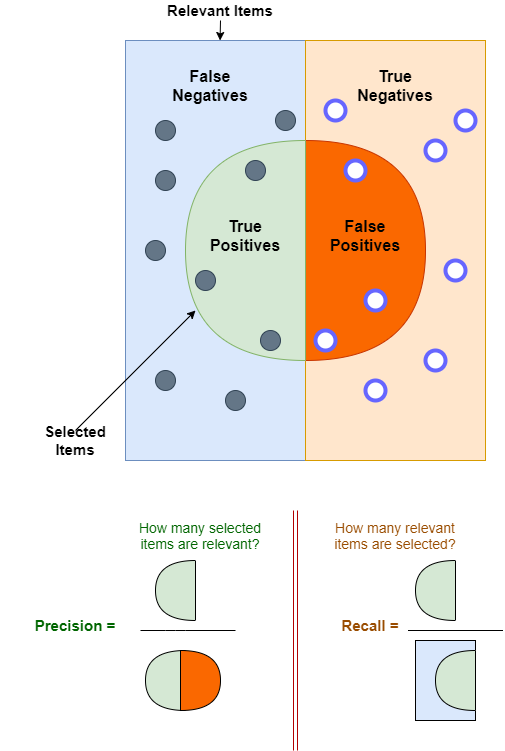

$Precision = \frac{tp}{tp + fp}$ ------------------------------
$Recall = \frac{tp}{tp + fn}$

In [ ]:
tn, fp, fn, tp = cm.ravel()
print(
    "True negatives:  {}\nFalse positives: {}\nFalse negatives: {}\nTrue positives:  {}\n".format(
        tn, fp, fn, tp
    )
)

print("Precision : {:.2f}\n".format(precision_score(y_true, y_pred)))
print("Recall    : {:.2f}\n".format(recall_score(y_true, y_pred)))